# Exploring the Outer Reaches of the DP0.2 Simulated Milky Way

Contact author: Jeff Carlin

Last verified to run on ???? with LSST Science Pipelines release version ???.

## Introduction

The goal of this notebook is to explore what we can learn about the structure of the Milky Way from the DP0.2 dataset. In particular, the 

BHB history/intro, BHBs as distance indicators, Milky Way halo, etc.


- *Use this space to provide a brief description of what people will learn from this notebook.*
- *Include links to any information or precursor tutorials that would be useful.*
- *Give credit to all individuals who have contributed to this notebook or whose work this notebook is based on, if applicable.*

## 1.0 Set Up

In [2]:
# Import general python packages
import time
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import pandas
from pandas.testing import assert_frame_equal
from astropy import units as u
from astropy.coordinates import SkyCoord
import dustmaps
from dustmaps.sfd import SFDQuery
from dustmaps.config import config

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# To ignore some kinds of warnings
#import warnings
#from astropy.units import UnitsWarning

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


In [3]:
# Set up some plotting defaults:

params = {'axes.labelsize': 24,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 5],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [3]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

In [4]:
results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp02_dc2_catalogs.Object'")
sch = results.to_table()

## 1.1 Data Query 

We'll query the Object table over the entire region of sky covered by DP0.2, specifying the following selection criteria:

a) -0.3 < (g-r) < 0.0 (blue colors typical of BHB stars)

b) g < 26 (there shouldn't be stars fainter than this anyway, but a BHB star at 26th mag would be > 600 kpc away, which is unrealistic for the Milky Way)

c) refExtendedness < 0.5 (objects classified as "not extended," i.e., point sources)


In [11]:
# Define the query
query = "SELECT objectId, coord_ra, coord_dec, "\
        "scisql_nanojanskyToAbMag(u_psfFlux) as umag, "\
        "scisql_nanojanskyToAbMag(g_psfFlux) as gmag, "\
        "scisql_nanojanskyToAbMag(r_psfFlux) as rmag, "\
        "scisql_nanojanskyToAbMag(i_psfFlux) as imag, "\
        "scisql_nanojanskyToAbMag(z_psfFlux) as zmag, "\
        "scisql_nanojanskyToAbMag(y_psfFlux) as ymag, "\
        "scisql_nanojanskyToAbMagSigma(u_psfFlux, u_psfFluxErr) as umagerr, "\
        "scisql_nanojanskyToAbMagSigma(g_psfFlux, g_psfFluxErr) as gmagerr, "\
        "scisql_nanojanskyToAbMagSigma(r_psfFlux, r_psfFluxErr) as rmagerr, "\
        "scisql_nanojanskyToAbMagSigma(i_psfFlux, i_psfFluxErr) as imagerr, "\
        "scisql_nanojanskyToAbMagSigma(z_psfFlux, z_psfFluxErr) as zmagerr, "\
        "scisql_nanojanskyToAbMagSigma(y_psfFlux, y_psfFluxErr) as ymagerr, "\
        "tract, patch, i_extendedness, refExtendedness "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE (scisql_nanojanskyToAbMag(g_psfFlux)-scisql_nanojanskyToAbMag(r_psfFlux)) < 0.0 "\
        "AND (scisql_nanojanskyToAbMag(g_psfFlux)-scisql_nanojanskyToAbMag(r_psfFlux)) > -0.3 "\
        "AND scisql_nanojanskyToAbMag(g_psfFlux) < 26.0 "\
        "AND refExtendedness < 0.5"


### 1.1.1 Query the Object table

The next cell executes the query. _Warning: it may take at least 15 minutes to return a result._

_If you have already executed the query and saved the results as a FITS file, skip ahead to Section 1.1.2._

In [12]:
%%time
bhb_gr_color = service.search(query)
print('Query returned %s matched objects.' % len(bhb_gr_color))

Query returned 1699914 matched objects.
CPU times: user 1min 21s, sys: 1.21 s, total: 1min 23s
Wall time: 16min 31s


Instead of waiting for the query in the above cell to complete, you can submit an _asynchronous_ query. The following cells show how to do the same query asynchronously.

In [ ]:
#job = service.submit_job(query)

#print('Job URL is', job.url)

In [ ]:
#print('Job phase is', job.phase)

In [ ]:
#job.execution_duration

In [ ]:
#bhb_gr_color = job.fetch_result().to_table() #.to_pandas()

In [5]:
#bhb_gr_color_tab = bhb_gr_color.to_table()

In [19]:
#bhb_gr_color_tab.write('bhb_dp02_gr_selection.fits', overwrite=True)

### 1.1.2 Read the data from the saved FITS file

If you have already executed the query and saved it as a FITS file, you can simply read that file and proceed.

In [4]:
from astropy.io import fits
#bhb_gr_color0 = fits.getdata('bhb_dp02_gr_selection.fits')
bhb_gr_color0 = fits.getdata('../../scratch/bhb_dp02_gr_selection.fits')

from astropy.table import Table
bhb_gr_color = Table(bhb_gr_color0)

In [5]:
bhb_gr_color.columns

<TableColumns names=('objectId','coord_ra','coord_dec','umag','gmag','rmag','imag','zmag','ymag','umagerr','gmagerr','rmagerr','imagerr','zmagerr','ymagerr','tract','patch','i_extendedness')>

### 1.1.3 Correct the magnitudes for extinction

We will look up the reddening values, E(B-V), from the maps of [Schlegel, Finkbeiner, & Davis (1998)](https://ui.adsabs.harvard.edu/abs/1998ApJ...500..525S/abstract) using the `dustmaps` package. Then we convert them to per-band extinction values using the coefficients derived for DC2 in this [notebook](https://github.com/LSSTDESC/DC2-analysis/blob/master/contributed/Derive_A_EBV_coefficients.ipynb) by Sam Schmidt (see also [this demo](https://github.com/LSSTDESC/DC2-analysis/blob/master/contributed/DC2_object_deredden.ipynb) showing how to apply the corrections).

In [6]:
# set the A_lamba/E(B-V) values for the six ugrizy LSST filters 
band_a_ebv = np.array([4.81, 3.64, 2.70, 2.06, 1.58, 1.31])

`dustmaps` expects coordinates to be in Astropy "SkyCoord" format.

In [7]:
coords = SkyCoord(bhb_gr_color['coord_ra'], bhb_gr_color['coord_dec'], unit = 'deg', frame='fk5')

Execute the `dustmaps` query and add the E(B-V) values to the table:

In [8]:
sfd = SFDQuery()
ebvvec = sfd(coords)
bhb_gr_color.add_column(ebvvec, name='ebv')

Now apply the coefficients to get per-band extinction, then correct the magnitudes for the extinction (i.e., xmag0 = xmag - A_x * E(B-V), where "x" is each band).

In [9]:
u0 = bhb_gr_color['umag'] - bhb_gr_color['ebv']*band_a_ebv[0]
g0 = bhb_gr_color['gmag'] - bhb_gr_color['ebv']*band_a_ebv[1]
r0 = bhb_gr_color['rmag'] - bhb_gr_color['ebv']*band_a_ebv[2]
i0 = bhb_gr_color['imag'] - bhb_gr_color['ebv']*band_a_ebv[3]
z0 = bhb_gr_color['zmag'] - bhb_gr_color['ebv']*band_a_ebv[4]

For convenience, we'll extract extinction-corrected colors into arrays:

In [10]:
ug0 = u0-g0
ui0 = u0-i0
gr0 = g0-r0
rz0 = r0-z0
ri0 = r0-i0
iz0 = i0-z0

## 2.0 Examine color-color plots

The method of selecting blue horizontal branch (BHB) stars that we intend to develop in this notebook is based on their unique locus in color-color space. First, let's look at a couple of color-color plots:

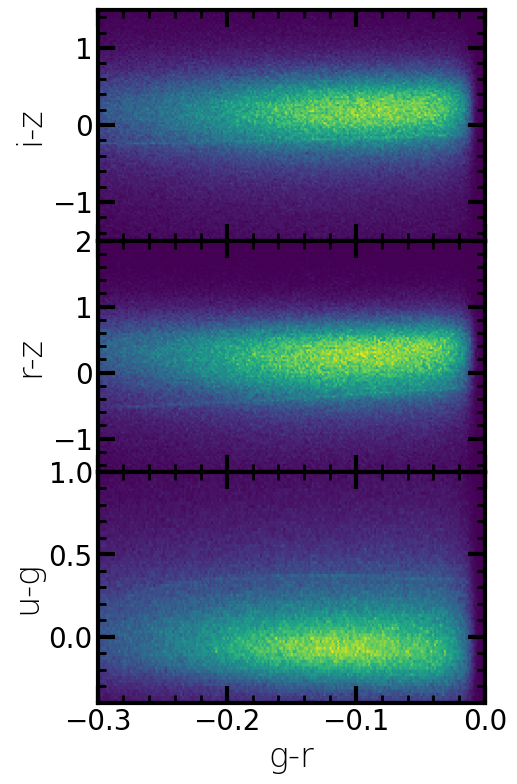

In [73]:
fig, ax = plt.subplots(3, 1, figsize=(5, 9))

plt.subplots_adjust(hspace=0) 

plt.sca(ax[0])
plt.hexbin(gr0, iz0, gridsize=200, extent=(-0.3, 0.0, -1.5, 1.5))
plt.xlim(-0.3, 0.0)
plt.ylim(-1.5, 1.5)
plt.minorticks_on()
plt.ylabel('i-z')
ax[0].xaxis.set_ticklabels([])

plt.sca(ax[1])
plt.hexbin(gr0, rz0, gridsize=200, extent=(-0.3, 0.0, -1.5, 2.0))
plt.xlim(-0.3, 0.0)
plt.ylim(-1.5, 2)
plt.minorticks_on()
plt.ylabel('r-z')
ax[1].xaxis.set_ticklabels([])

plt.sca(ax[2])
plt.hexbin(gr0, ug0, gridsize=200, extent=(-0.3, 0.0, -1.3, 1.0))
plt.xlim(-0.3, 0.0)
plt.ylim(-0.4, 1.0)
plt.minorticks_on()
plt.xlabel('g-r')
plt.ylabel('u-g')
plt.show()

## 2.1 Select the BHB candidates

You may have noticed a narrow stripe cutting across all three of those color-color plots. Let's try to develop a way to select that stripe. It's a clear overdensity, and mostly horizontal, so we will try binning the data in the colors that are on the vertical axis in each plot, then see if there is a peak.

We'll do the following:
1. use a 2D histogram to bin the data, 
2. fit a polynomial to the overall distribution in each slice of (g-r) color,
3. subtract off the polynomial from the profile,
4. look for peaks in the residuals.

Because the BHB locus is a narrow stripe, it should remain after subtracting the smooth, low-order polynomial.

### 2.1.1 Select in (r-z) vs. (g-r)

In [74]:
nbins=30
hist_grrz = np.histogram2d(gr0, rz0, range=[[-0.3, 0.0], [-1, 0]], bins=nbins)

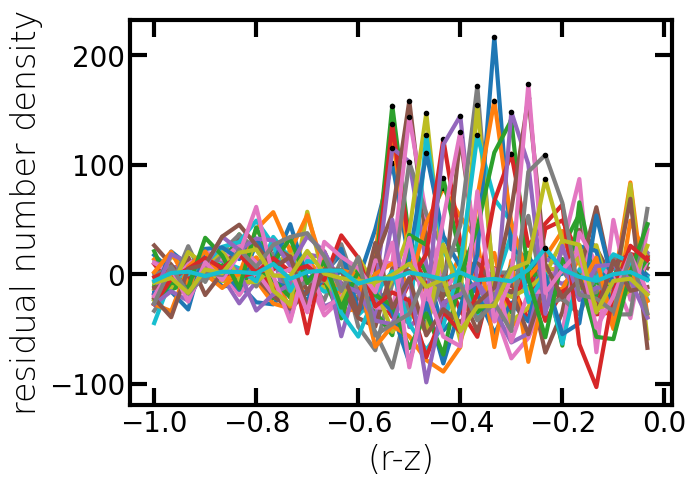

In [75]:
gr_binvals = []
rz_binvals = []

for x in range(nbins):
    poly = Polynomial.fit(hist_grrz[2][:-1], hist_grrz[0][x], deg=3)
    resid = hist_grrz[0][x]-poly(hist_grrz[2][:-1])
    plt.plot(hist_grrz[2][:-1], resid)
    peak = np.argmax(resid)
    plt.plot(hist_grrz[2][peak], resid[peak], 'k.')
    gr_binvals.append(hist_grrz[1][x])
    rz_binvals.append(hist_grrz[2][peak])
    # plt.plot(hist_grrz[2][:-1], hist_grrz[0][x])

plt.xlabel('(r-z)')
plt.ylabel('residual number density')
plt.show()

All we did was pick the highest peak in the residuals, and it looks like it may have worked. Let's fit a polynomial to the peaks we extracted.

In [76]:
poly_grrz0 = Polynomial.fit(gr_binvals, rz_binvals, deg=2)

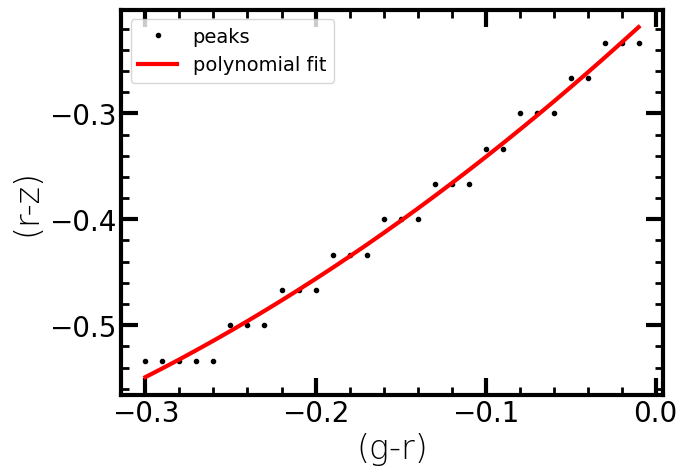

In [77]:
plt.plot(gr_binvals, rz_binvals, 'k.', label='peaks')
plt.plot(gr_binvals, poly_grrz0(np.array(gr_binvals)), 'r', label='polynomial fit')
plt.legend()
plt.xlabel('(g-r)')
plt.ylabel('(r-z)')
plt.minorticks_on()
plt.show()

Those were coarse bins. Let's try a finer scale:

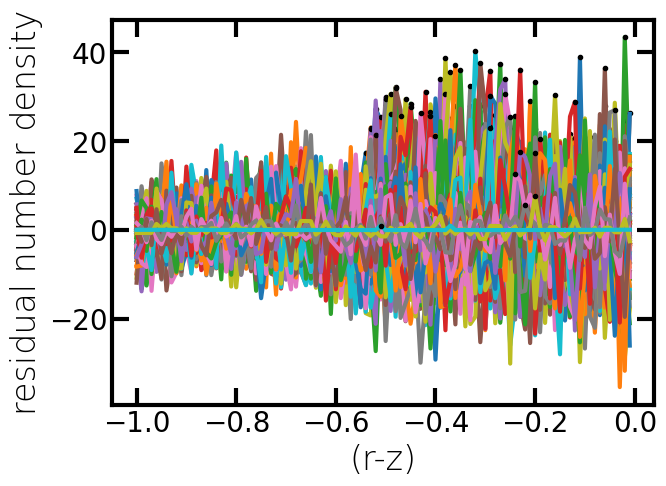

In [78]:
nbins=100
hist_grrz = np.histogram2d(gr0, rz0, range=[[-0.3, 0.0], [-1, 0]], bins=nbins)

gr_binvals = []
rz_binvals = []

for x in range(nbins):
    poly = Polynomial.fit(hist_grrz[2][:-1], hist_grrz[0][x], deg=3)
    resid = hist_grrz[0][x]-poly(hist_grrz[2][:-1])
    plt.plot(hist_grrz[2][:-1], resid)
    peak = np.argmax(resid)
    plt.plot(hist_grrz[2][peak], resid[peak], 'k.')
    gr_binvals.append(hist_grrz[1][x])
    rz_binvals.append(hist_grrz[2][peak])

plt.xlabel('(r-z)')
plt.ylabel('residual number density')

plt.show()

With finer bins, there will be some outliers. We'll calculate residuals relative to the previous, coarse polynomial to filter out points with large residuals, then fit a new polynomial.

In [79]:
rz_resid = rz_binvals-poly_grrz0(np.array(gr_binvals))
keepers = np.abs(rz_resid) < 0.05
gr_keepers = np.array(gr_binvals)[keepers]
rz_keepers = np.array(rz_binvals)[keepers]

poly_grrz = Polynomial.fit(gr_keepers, rz_keepers, deg=2)


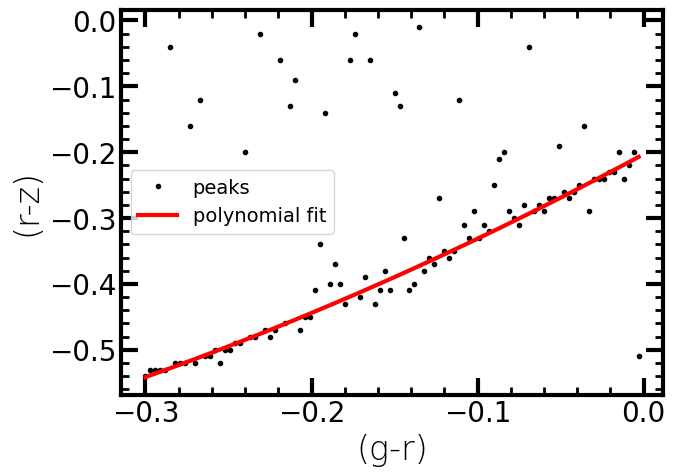

In [81]:
plt.plot(gr_binvals, rz_binvals, 'k.', label='peaks')
plt.plot(gr_binvals, poly_grrz(np.array(gr_binvals)), 'r', label='polynomial fit')
plt.legend()
plt.xlabel('(g-r)')
plt.ylabel('(r-z)')
plt.minorticks_on()
plt.show()

In [82]:
# Print the polynomial fit coefficients:
poly_grrz.coef

array([-0.39301833,  0.16514863,  0.01666139])

### 2.1.2 Select in (i-z) vs. (g-r)

Same process as before, but using (i-z) this time.

In [83]:
nbins=35
hist_griz = np.histogram2d(gr0, iz0, range=[[-0.3, 0.0], [-0.7, 0.2]], bins=nbins)

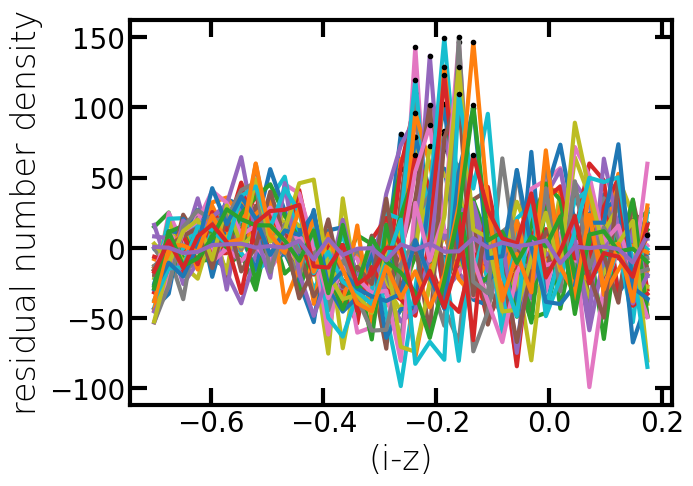

In [84]:
gr_binvals = []
iz_binvals = []

for x in range(nbins):
    poly = Polynomial.fit(hist_griz[2][:-1], hist_griz[0][x], deg=3)
    resid = hist_griz[0][x]-poly(hist_griz[2][:-1])
    plt.plot(hist_griz[2][:-1], resid)
    peak = np.argmax(resid)
    plt.plot(hist_griz[2][peak], resid[peak], 'k.')
    gr_binvals.append(hist_griz[1][x])
    iz_binvals.append(hist_griz[2][peak])

plt.xlabel('(i-z)')
plt.ylabel('residual number density')

plt.show()

In [85]:
poly_griz0 = Polynomial.fit(gr_binvals[:-1], iz_binvals[:-1], deg=3)

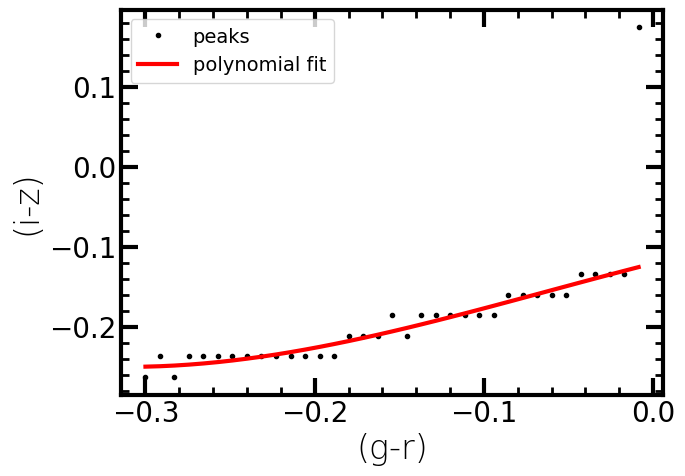

In [86]:
plt.plot(gr_binvals, iz_binvals, 'k.', label='peaks')
plt.plot(gr_binvals, poly_griz0(np.array(gr_binvals)), 'r', label='polynomial fit')
plt.legend()
plt.xlabel('(g-r)')
plt.ylabel('(i-z)')
plt.minorticks_on()
plt.show()

In [87]:
nbins=100
hist_griz = np.histogram2d(gr0, iz0, range=[[-0.3, 0.0], [-0.7, 0.2]], bins=nbins)

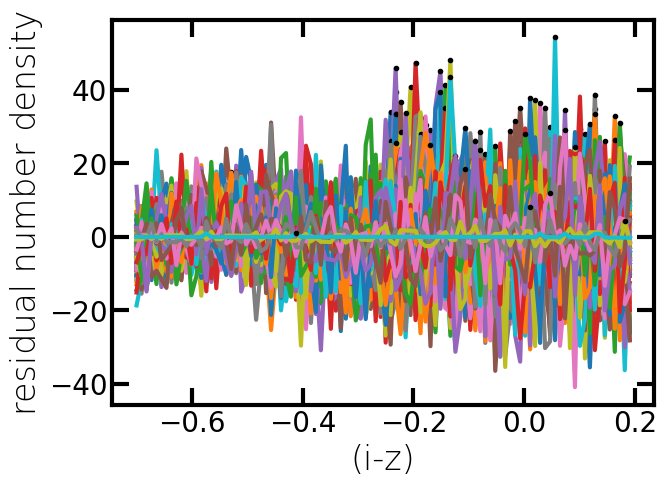

In [88]:
gr_binvals = []
iz_binvals = []

for x in range(nbins):
    poly = Polynomial.fit(hist_griz[2][:-1], hist_griz[0][x], deg=3)
    resid = hist_griz[0][x]-poly(hist_griz[2][:-1])
    plt.plot(hist_griz[2][:-1], resid)
    peak = np.argmax(resid)
    plt.plot(hist_griz[2][peak], resid[peak], 'k.')
    gr_binvals.append(hist_griz[1][x])
    iz_binvals.append(hist_griz[2][peak])

plt.xlabel('(i-z)')
plt.ylabel('residual number density')

plt.show()

In [89]:
iz_resid = iz_binvals-poly_griz0(np.array(gr_binvals))
keepers = np.abs(iz_resid) < 0.05
gr_keepers = np.array(gr_binvals)[keepers]
iz_keepers = np.array(iz_binvals)[keepers]

poly_griz = Polynomial.fit(gr_keepers, iz_keepers, deg=2)

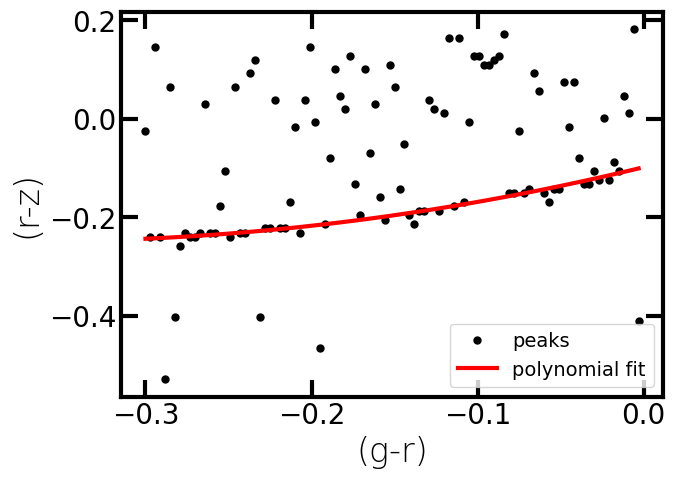

In [90]:
plt.plot(gr_binvals, iz_binvals, 'k.', ms=10, label='peaks')
plt.plot(gr_binvals, poly_griz(np.array(gr_binvals)), 'r', label='polynomial fit')
plt.legend()
plt.xlabel('(g-r)')
plt.ylabel('(r-z)')
plt.show()

### 2.1.3 Select in (u-g) vs. (g-r)

Same process as before, but using (u-g) this time.

In [92]:
nbins=15
hist_grug = np.histogram2d(gr0, ug0, range=[[-0.3, -0.05], [0.0, 0.5]], bins=nbins)

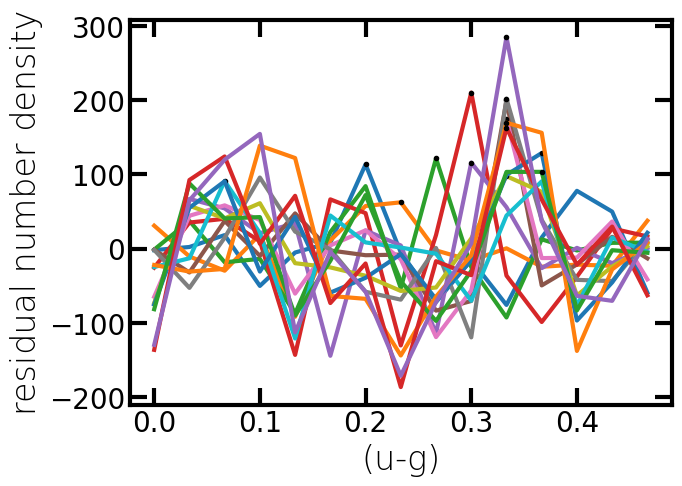

In [94]:
gr_binvals = []
ug_binvals = []

for x in range(nbins):
    poly = Polynomial.fit(hist_grug[2][:-1], hist_grug[0][x], deg=3)
    resid = hist_grug[0][x]-poly(hist_grug[2][:-1])
    plt.plot(hist_grug[2][:-1], resid)
    peak = np.argmax(resid)
    plt.plot(hist_grug[2][peak], resid[peak], 'k.')
    gr_binvals.append(hist_grug[1][x])
    ug_binvals.append(hist_grug[2][peak])

plt.xlabel('(u-g)')
plt.ylabel('residual number density')

plt.show()

In [95]:
poly_grug0 = Polynomial.fit(gr_binvals, ug_binvals, deg=2)

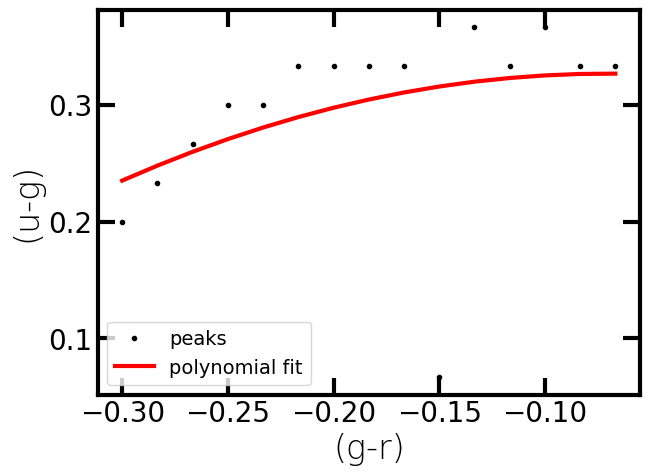

In [96]:
plt.plot(gr_binvals, ug_binvals, 'k.', label='peaks')
plt.plot(gr_binvals, poly_grug0(np.array(gr_binvals)), 'r', label='polynomial fit')
plt.legend()
plt.xlabel('(g-r)')
plt.ylabel('(u-g)')
plt.show()

In [97]:
nbins=25
hist_grug = np.histogram2d(gr0, ug0, range=[[-0.3, -0.05], [0.0, 0.5]], bins=nbins)

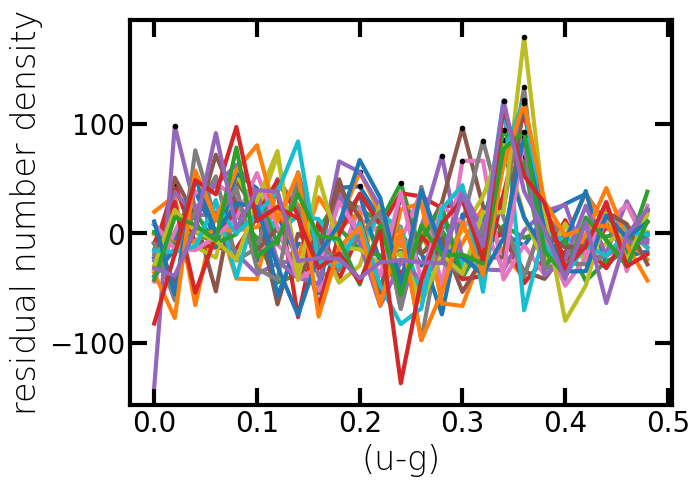

In [98]:
gr_binvals = []
ug_binvals = []

for x in range(nbins):
    poly = Polynomial.fit(hist_grug[2][:-1], hist_grug[0][x], deg=3)
    resid = hist_grug[0][x]-poly(hist_grug[2][:-1])
    plt.plot(hist_grug[2][:-1], resid)
    peak = np.argmax(resid)
    plt.plot(hist_grug[2][peak], resid[peak], 'k.')
    gr_binvals.append(hist_grug[1][x])
    ug_binvals.append(hist_grug[2][peak])

plt.xlabel('(u-g)')
plt.ylabel('residual number density')

plt.show()

In [99]:
ug_resid = ug_binvals-poly_grug0(np.array(gr_binvals))
keepers = np.abs(ug_resid) < 0.025
gr_keepers = np.array(gr_binvals)[keepers]
ug_keepers = np.array(ug_binvals)[keepers]

poly_grug = Polynomial.fit(gr_keepers, ug_keepers, deg=2)

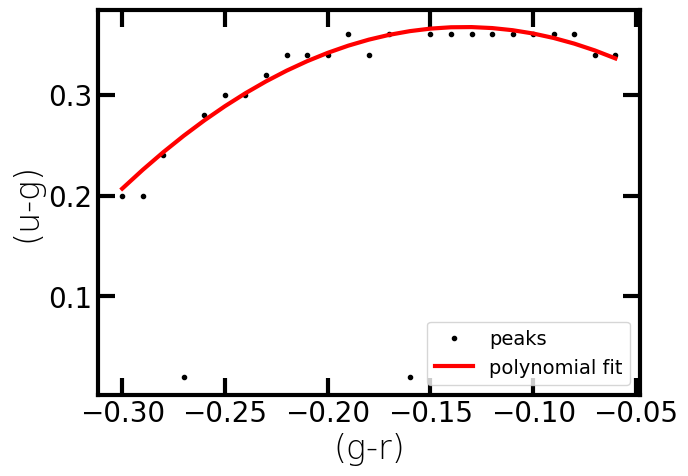

In [100]:
plt.plot(gr_binvals, ug_binvals, 'k.', label='peaks')
plt.plot(gr_binvals, poly_grug(np.array(gr_binvals)), 'r', label='polynomial fit')
plt.legend()
plt.xlabel('(g-r)')
plt.ylabel('(u-g)')
plt.show()

In [101]:
print(poly_griz.coef)
print(poly_grrz.coef)
print(poly_grug.coef)

[-0.19891567  0.06643539  0.02187428]
[-0.39301833  0.16514863  0.01666139]
[ 0.35963069  0.046521   -0.06992835]


## 2.2 Use the fits to extract BHB candidates

Now that we have fit the location of the BHB stars in color-color space, we can use the fits to extract a sample of candidate BHB stars. Our selection criteria will be:

1. -0.3 < (g-r) < 0.05
2. (i-z) > -0.05
3. within 0.03 mags of polynomial in (r-z) vs. (g-r)
4. within 0.03 mags of polynomial in (i-z) vs. (g-r)
5. within 0.05 mags of polynomial in (u-g) vs. (g-r)

In [105]:
lowergr = -0.3
uppergr = 0.05
upperiz = -0.05
color_color_cut_griz = poly_griz(gr0)
color_color_cut_grz = poly_grrz(gr0)
color_color_cut_grug = poly_grug(gr0)

sel_gr_lower = (gr0 > lowergr)
sel_gr_upper = (gr0 < uppergr)
sel_iz_upper = (iz0 < upperiz)
sel_griz_lower = (iz0 > color_color_cut_griz - 0.03)
sel_griz_upper = (iz0 < color_color_cut_griz + 0.03)
sel_grz_lower = (rz0 > color_color_cut_grz - 0.03)
sel_grz_upper = (rz0 < color_color_cut_grz + 0.03)
sel_grug_lower = (ug0 > color_color_cut_grug - 0.05)
sel_grug_upper = (ug0 < color_color_cut_grug + 0.05)

sel = sel_gr_lower & sel_gr_upper & sel_iz_upper & sel_griz_lower & \
      sel_griz_upper & sel_grz_lower & sel_grz_upper & sel_grug_lower & sel_grug_upper

### 2.2.1 Check that the selection picked the narrow feature we were after:

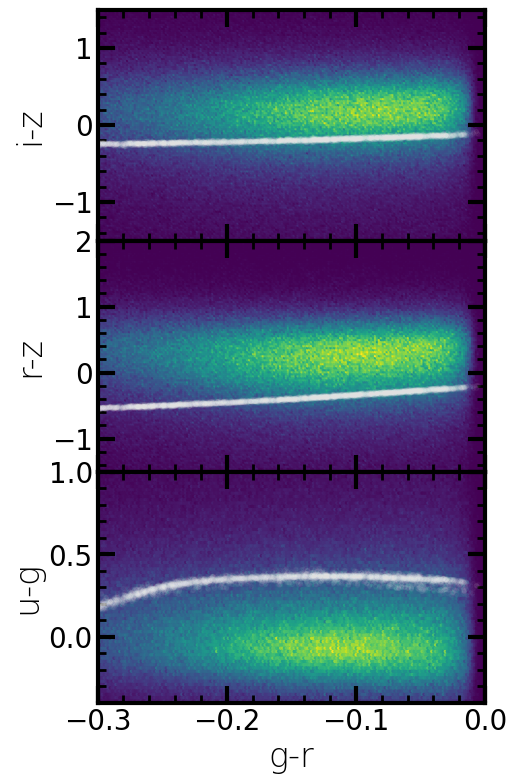

In [106]:
fig, ax = plt.subplots(3, 1, figsize=(5, 9))

plt.subplots_adjust(hspace=0) 

plt.sca(ax[0])
plt.hexbin(gr0, iz0, gridsize=200, extent=(-0.3, 0.0, -1.5, 1.5))
plt.plot(gr0[sel], iz0[sel], 'w.', alpha=0.03)
plt.xlim(-0.3, 0.0)
plt.ylim(-1.5, 1.5)
plt.minorticks_on()
plt.ylabel('i-z')
ax[0].xaxis.set_ticklabels([])

plt.sca(ax[1])
plt.hexbin(gr0, rz0, gridsize=200, extent=(-0.3, 0.0, -1.5, 2.0))
plt.plot(gr0[sel], rz0[sel], 'w.', alpha=0.03)
plt.xlim(-0.3, 0.0)
plt.ylim(-1.5, 2)
plt.minorticks_on()
plt.ylabel('r-z')
ax[1].xaxis.set_ticklabels([])

plt.sca(ax[2])
plt.hexbin(gr0, ug0, gridsize=200, extent=(-0.3, 0.0, -1.3, 1.0))
plt.plot(gr0[sel], ug0[sel], 'w.', alpha=0.03)
plt.xlim(-0.3, 0.0)
plt.ylim(-0.4, 1.0)
plt.minorticks_on()
plt.xlabel('g-r')
plt.ylabel('u-g')
plt.show()

Hooray - it looks like we've selected stars that are part of that feature! Now on to the science!

## 3.0 BHB density profile of the (DC2) Milky Way

In this section, we will derive distances to the BHB stars using a relationship from the literature. Then we will extract a radial density profile of BHB stars in the Milky Way.

From [Deason et al. 2011](https://ui.adsabs.harvard.edu/abs/2011MNRAS.416.2903D/abstract), the absolute magnitudes of BHB stars are related to their colors by:

M_g,BHB = 0.434 − 0.169(g − r) + 2.319(g − r)^2 +20.449(g − r)^3 + 94.517(g − r)^4

_Caveat: this relation is based on SDSS data. One should rederive the relation for DC2 to do this properly. Nonetheless, this likely only contributes a few percent error to the distances._

In [107]:
def bhbMagToDistKpc(gmag, rmag):
    gr = gmag-rmag
    M_g = 0.434 - (0.169*gr) + 2.319*(gr**2) + 20.449*(gr**3) + 94.517*(gr**4)
    distmod = gmag-M_g
    dist_pc = 10.0**((distmod + 5.0)/5.0)
    dist_kpc = dist_pc/1000.0
    return dist_kpc

In [110]:
# Get distances for our candidates:

bhb_dist_kpc = bhbMagToDistKpc(g0[sel], r0[sel])

In [111]:
from astropy.coordinates import SkyCoord
import astropy.units as u

sc_bhb = SkyCoord(ra=bhb_gr_color[sel]['coord_ra']*u.deg,
                  dec=bhb_gr_color[sel]['coord_dec']*u.deg,
                  distance=bhb_dist_kpc*u.kpc)

The distances are as measured from the Sun ("heliocentric"). Since we're interested in the Milky Way's radial density profile, convert the distances to Galactocentric, then calculate the radial distance from the Galactic center.

In [113]:
rad_bhb = np.sqrt(sc_bhb.galactocentric.x**2 + sc_bhb.galactocentric.y**2 + sc_bhb.galactocentric.z**2)

In [116]:
binwidth_kpc = 10.0
radbins = np.arange(0, 600, binwidth_kpc)
nbhb_bins, bhb_bin_edges = np.histogram(rad_bhb.value, bins=radbins)
bin_edges = bhb_bin_edges[:-1]
bin_centers = bin_edges+(binwidth_kpc/2)
volume_bins = np.array([(4.0/3.0)*np.pi*(((rad+binwidth_kpc)**3)-(rad**3)) for rad in bin_edges])
bhb_density_bins = nbhb_bins/volume_bins

nbhb_sel_bins, bhb_sel_bin_edges = np.histogram(rad_bhb.value, bins=radbins)
bhb_sel_density_bins = nbhb_sel_bins/volume_bins


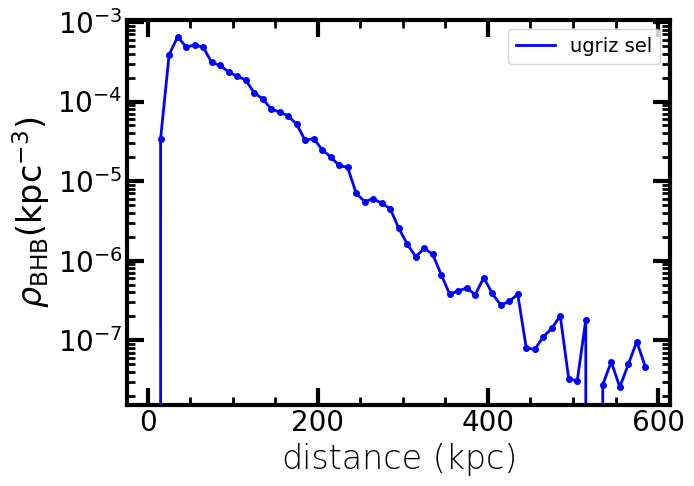

In [128]:
plt.plot(bin_centers, bhb_density_bins, linewidth=2, color='Blue', label='ugriz sel')
plt.plot(bin_centers, bhb_density_bins, 'b.', ms=8, label='__none__')
plt.xlabel(r'distance (kpc)')
plt.ylabel(r'$\rho_{\rm BHB} ({\rm kpc}^{-3})$')
plt.legend()
plt.semilogy()
plt.minorticks_on()
plt.show()

### 3.1 Power-law fit

We fit a powerlaw to the density profile of the form $\rho \propto R^{-n}$, where $R$ is the Galactocentric radius, $\rho$ is the BHB density as a function of $R$, and $n$ is the powerlaw index.

Note that because BHB stars at distances $\lesssim 50$ kpc are bright and often saturated in the DC2 dataset, we limit the fit to $70 < R < 300$ kpc. We use the `numpy` function `polyfit`:

In [121]:
okfit_bins = (bin_centers > 70.0) & (bin_centers < 300.0)
bhb_sel_powerlaw_fit = np.polyfit(bin_centers[okfit_bins], np.log10(bhb_sel_density_bins[okfit_bins]), 1)
print('Powerlaw fit: ', bhb_sel_powerlaw_fit)

bhb_sel_powerlaw = np.poly1d(bhb_sel_powerlaw_fit)

Powerlaw fit:  [-0.00951061 -2.69184024]


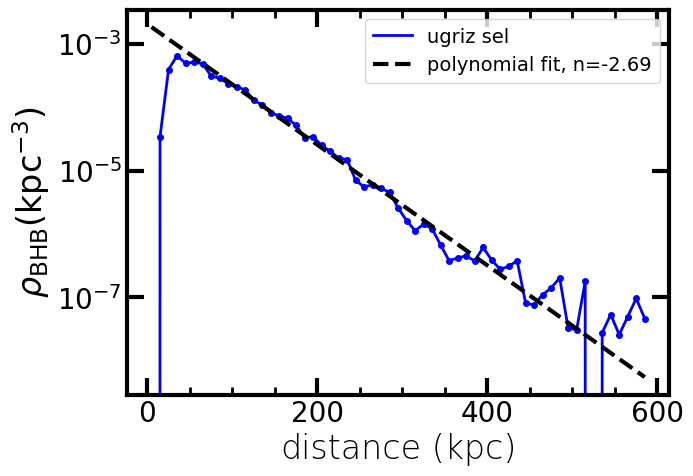

In [129]:
plt.plot(bin_centers, bhb_density_bins, linewidth=2, color='Blue', label='ugriz sel')
plt.plot(bin_centers, bhb_density_bins, 'b.', ms=8, label='__none__')
plt.plot(bin_centers, 10.0**bhb_sel_powerlaw(bin_centers), linestyle='--', color='black',
         label='polynomial fit, n='+f'{bhb_sel_powerlaw_fit[1]:.2f}')
plt.xlabel(r'distance (kpc)')
plt.ylabel(r'$\rho_{\rm BHB} ({\rm kpc}^{-3})$')
plt.legend()
plt.semilogy()
plt.minorticks_on()
plt.show()

From [Juric et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...673..864J/abstract), Table 5, the best fit halo density profile from SDSS goes as $\sim R^{-2.8}$. The `galfast` model that went into DC2 used the Milky Way parameters from Juric+2008, so our "expected" result for the powerlaw should be $n_{expected} = 2.8$. We find $n = 2.7$, which is pretty excellent agreement given our rather simple methods!

#### Notes:

- Not accounting for non-spherical halo (e.g., Juric+2008 found oblate halo with q~0.6)
- Haven't included error bars (on either density bins, or profile fits)
- Are there really stars out to 600 kpc in DC2? (Check the galfast code to see if there's a truncation radius.)
